In [1]:
import sys
import os
from pathlib import Path
path_dcf = str(Path(os.path.abspath('.')).resolve().parent)
sys.path.append(path_dcf)
from algorithms.unsupervised_dcf import DCF
from torch_contour import CleanContours
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from utils import define_contour_init
import torch


### Choose an image to perform unsupervised DCF

In [2]:
filename = "lion.jpg"
height = 512
img = plt.imread(os.path.join(path_dcf,"images_test", filename))
img = cv2.resize(img, (height,height), interpolation = cv2.INTER_AREA).astype(np.int32)
tensor = (torch.tensor(np.moveaxis(img,-1,0)[None])/255).to(torch.device("mps"))

### Instantiate DCF Unsupervised

In [3]:
dcf = DCF(
    n_epochs=300,
    learning_rate=2e-3,
    area_force=1e-3,
    exponential_decay=0.999,
    sigma=1,
    clip = 1e-1,
    early_stopping_patience=100,
    early_stopping_threshold=1e-4,
    use_mixed_precision=True,
)


INFO:algorithms.unsupervised_dcf:DCF initialized with 300 epochs, lr=0.002


### Define initial contour and predict

In [4]:
### set an initial contour and normalize it to [0,1]
contour_init, mask = define_contour_init(
    height, center=[250, 250], axes=[250, 250], angle=0
)
shape = img.shape[:-1]
x = contour_init / np.array(shape)

### Change the initial contour to set up a number of nobes
nb_nodes = 100
c = CleanContours()
contour_init = c.interpolate(x, nb_nodes).clip(0, 1)

### predict
contour_init = torch.tensor(contour_init)[None, None].to(torch.float32).to(torch.device("mps"))
contours, loss_history, final_contours = dcf.predict(tensor, contour_init)

INFO:algorithms.unsupervised_dcf:Starting contour evolution...
Optimizing contour:  73%|███████▎  | 220/300 [00:05<00:01, 43.33it/s]
INFO:algorithms.unsupervised_dcf:Contour stopped
INFO:algorithms.unsupervised_dcf:Prediction completed successfully


### Show the result of the evolution of the contour 

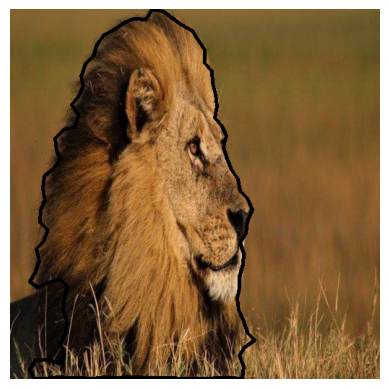

In [5]:
new_img = cv2.drawContours(
    (((img / np.max(img)) * 255).astype(np.uint8)).copy(),
    final_contours.astype(int),
    0,
    color=1,
    thickness=4,
)
plt.imshow(new_img)
plt.axis('off')
plt.show()

### Save the images of the deformation over time

In [7]:
import matplotlib
cmap = matplotlib.cm.get_cmap("cool")

colors = [cmap(u)[:-1] for u in np.linspace(0, 1, dcf.n_epochs + 1)]
colors = (np.array(colors) * 255).astype(np.int32).tolist()

tots = []
imgs = []
# print(contours.shape)
for i, contour in enumerate(contours):
    print(contour.shape)
    new_img = cv2.drawContours(
        (((img / np.max(img)) * 255).astype(np.uint8)).copy(),
        contour.astype(int),
        0,
        color=colors[0],
        thickness=4,
    )
    plt.imsave(
        filename.split(".")[0] + str(i) + ".png",
        new_img,
    )

/var/folders/fg/s__266w50f7gt47qyzmbdc700000gq/T/ipykernel_57509/3570281085.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("cool")


(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100, 2)
(1, 1, 100